# Self-Driving Car Engineer Nanodegree
## Deep Learning
## Project: Build a Traffic Sign Recognition Classifier

## Step 0: Load The Data

In [1]:
# Utility packages
import numpy as np

# Printing helper packages
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Load pickled data
import pickle

# Load training and testing data

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

## Step 1: Dataset Summary & Exploration

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### test set to ensure every thing is valid
assert(len(X_train) == len(y_train))
assert(len(X_test) == len(y_test))

### Data Set Summary

# Number of training examples
n_train = len(X_train)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(np.concatenate((y_train, y_test), axis=0), return_counts=True)[0])

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


(32, 32)


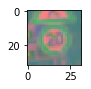

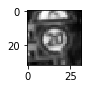

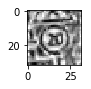

In [12]:
import cv2
x = X_train[0]
img_yuv = cv2.cvtColor(x, cv2.COLOR_RGB2YUV)
plt.figure(figsize=(1,1))
plt.imshow(img_yuv)
img_grey = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)
plt.figure(figsize=(1,1))
plt.imshow(img_grey,cmap='gray')
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(img_grey)
print(cl1.shape)
plt.figure(figsize=(1,1))
plt.imshow(cl1,cmap='gray')

### Include an exploratory visualization of the dataset
In cell 3 I show how each class is distributed over the dataset

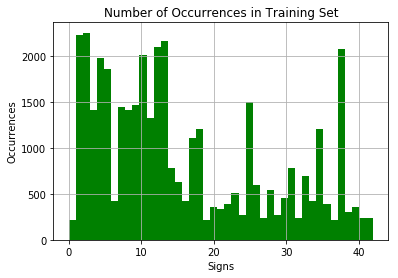

In [3]:
#The work on this cell is based on this
#https://github.com/deacons2016/traffic_signs/blob/master/Traffic_Sign_Classifier.ipynb
def load_label_file(file):
    lines = open(file).readlines()[1:]
    lines = [line.strip().split(",") for line in lines]
    label_descs = dict([ (int(classid), desc) for classid, desc in lines])
    return label_descs

label_descriptions = load_label_file("signnames.csv")

# the histogram of the training data
n, bins, patches = plt.hist(y_train, n_classes, facecolor='green')

plt.xlabel('Signs')
plt.ylabel('Occurrences')
plt.title('Number of Occurrences in Training Set')
plt.grid(True)

plt.show()

In cell 4, I picked random sample and show the image it represents. Also, I print the name of the class it belongs to and the class number.

Dangerous curve to the right 20


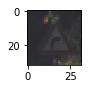

In [4]:
#Show random sample of training set
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image)
print(label_descriptions.get(y_train[index]),y_train[index])


## Step 2: Design and Test a Model Architecture
I went trhough some papers and i itried to implement some ideas I found. Also, I found some usful codes that belongs to other Udacity students. Here are a list of some resources I used:

1- http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf

2- https://arxiv.org/pdf/1511.02992.pdf

3- https://github.com/Deborah-Digges/SDC-ND/blob/master/P2-traffic-signs/Traffic_Signs_Recognition.ipynb

4- https://github.com/georgesung/traffic_sign_classification_german

5- https://chatbotslife.com/german-sign-classification-using-deep-learning-neural-networks-98-8-solution-d05656bf51ad#.jt0x1iuyh


### Pre-process the Data Set (normalization, grayscale, etc.)

I did four things for data preprocessing:
- Convert RGB to YUV and use Y channel only.
- Normalize Y channel
- Create augmented images based on translating image and rotating it.
- Write Python generator function that create 5 new images for each patch and apply the steps mentioned above.


Data preprocessing step is inpired by this work:
http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf

#### This will increase batch size from 128 to (5 * 128) + 128 = 768




In [5]:
### shuffle data
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

In [6]:
### add helper functions to randomly translate and rotate images
import cv2

def translateImage(image):
    t_x = (np.random.randn(1)*.5)[0]
    t_y = (np.random.randn(1)*.5)[0]
    #print(t_x,t_y)
    rows,cols,_ = image.shape
    M = np.float32([[1,0,t_x],[0,1,t_y]])
    dst = cv2.warpAffine(image,M,(cols,rows))
    return dst

def rotateImage(image):
    theta = (np.random.randn(1)*5)[0]
    #print(theta)
    rows,cols,_ = image.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),theta,1)
    dst = cv2.warpAffine(image,M,(cols,rows))
    return dst


In [7]:
### add helper function to create 5 new augmented images for each image

def generateAugmentedImages(X_data,y_data):
    num_images = 5 * len(X_data)
    x_aug = np.zeros(shape=(num_images,32,32,3)).astype(np.uint8)
    y_aug = np.zeros(shape=(num_images))
    aug_idx = 0
    for idx, img in enumerate(X_data):
        lbl = y_data[idx]
        for itr in range(5):
            new_image = translateImage(rotateImage(img))
            x_aug[aug_idx] = new_image
            y_aug[aug_idx] = lbl
            aug_idx = aug_idx + 1
    X_data = np.concatenate((X_data, x_aug), axis=0)
    y_data = np.concatenate((y_data, y_aug), axis=0)
    
    return X_data, y_data
    

#x,y = generateAugmentedImages(X_train[0:128],y_train[0:128])

#print(len(x),len(y))

In [8]:
### convert to YUV, extract Y and normalize it

def imagestoY(batch_x):
    for x in batch_x:
        img_out = cv2.cvtColor(x, cv2.COLOR_RGB2YUV)
        img_out = img_out[:,:,0].reshape(32,32,1)
        img_out = img_out - np.mean(img_out)
        yield img_out

In [ ]:
def imagetoCLAHE(batch_x):
    for x in batch_x:
        img_grey = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        cl1 = clahe.apply(img_grey)
        cl1 = cl1.reshape(32,32,1)
        yield cl1

In [9]:
### Python generator function that applied to fetch batches and do data preprocessing        
# https://github.com/justheuristic/prefetch_generator
def iterate_minibatches(num_examples, batch_size, X_data, y_data, is_training = 1):
    for offset in range(0, num_examples, batch_size):
        end = offset + batch_size
        batch_x, batch_y = X_data[offset:end], y_data[offset:end]
        if is_training == 1:
            batch_x, batch_y = generateAugmentedImages(batch_x, batch_y)
            batch_x, batch_y = shuffle(batch_x, batch_y)
        #batch_x = imagestoY(batch_x)
        batch_x = imagetoCLAHE(batch_x)
        yield batch_x,batch_y



### Split Data into Training, Validation and Testing Sets
I think about applying image augmentaion over each iteration instead of doing it before starting.

This make Training set increased by 5x in total = 188202. Also, batch size increased from 128 to 768

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation =   train_test_split(X_train, y_train, test_size=.2, random_state=0)

assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))

# Number of training examples
n_train = len(X_train)

# Number of validation examples.
n_validation = len(X_validation)

print("Number of training examples before augmentaion = {0} and after augmentation = {1}".format(n_train, n_train*6) )
print("Number of validation examples =", n_validation)


Number of training examples before augmentaion = 31367 and after augmentation = 188202
Number of validation examples = 7842


### Model Architecture

Model Arch is the same as LeNet but changed the depth of CONV layers to be 12 instead of 6 for the first CONV layer and 48 instead of 12 for the second one.

I also added a fully connected layer with 1200-400 followed by 400-120, 120-84, and 84-43

Finally, I added a dropout layer for each FC layer with keep prop of 80%.

For hyperparameters, I set Epochs to 10 and i did not increase it as i got good results (over 99% after the 9th iteration).

Also, I kept the batch size = 128 but inside the iteration itself and generate the images. Hint, the process was not slow as i use the CPU to create the images while the GPU is doing the math work.

My final model consisted of the following layers:

Layer	Description
Input	32x32x3 RGB image
Convolution 3x3	1x1 stride, same padding, outputs 32x32x64
RELU	
Max pooling	2x2 stride, outputs 16x16x64
Convolution 3x3	etc.
Fully connected	etc.
Softmax	etc.

| Layer | Description          
| :- | :-------------
|Input| 32x32x1 Y channel of Image
| Convolution | 5x5	1x1 stride, valid padding, outputs 28x28x12.
| RELU | Activation function adding non-linearity, outputs 28x28x12.
| Max pooling | 2x2 stride, valid padding, outputs 14x14x12.
| Convolution | 5x5	1x1 stride, valid padding, outputs 10x10x48.
| RELU | Activation function adding non-linearity, outputs 10x10x48.
| Max pooling | 2x2 stride, valid padding, outputs 5x5x48.
| Flatten | Input = 5x5x48. Output = 1200.
| Fully connected | Input = 1200. Output = 400.
| RELU | Activation function adding non-linearity, outputs 400.
| Dropout | With keep propability of .8, outputs 400.
| Fully connected | Input = 400. Output = 120.
| RELU | Activation function adding non-linearity, outputs 120.
| Dropout | With keep propability of .8, outputs 120.
| Fully connected | Input = 120. Output = 84.
| RELU | Activation function adding non-linearity, outputs 84.
| Dropout | With keep propability of .8, outputs 84.
| Fully connected | Input = 84. Output = 43.
| RELU | Activation function adding non-linearity, outputs 43.
| Dropout | With keep propability of .8, outputs 43.

In [11]:
import tensorflow as tf

EPOCHS = 10
BATCH_SIZE = 128

In [12]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x12.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 12), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(12))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x12. Output = 14x14x12.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x48.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 12, 48), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(48))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x48. Output = 5x5x48.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x48. Output = 1200.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 1200. Output = 400.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1200, 400), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(400))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Regularization.
    fc1    = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(120))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    
    # Regularization.
    fc2    = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 120. Output = 84.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(84))
    fc3    = tf.matmul(fc2, fc3_W) + fc3_b
    
    # Activation.
    fc3    = tf.nn.relu(fc3)
    
    # Regularization.
    fc3    = tf.nn.dropout(fc3, keep_prob)
    
    # Layer 6: Fully Connected. Input = 84. Output = 43.
    fc4_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc4_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc3, fc4_W) + fc4_b
    
    return logits

### Features and Labels

In [13]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)

### Training Pipeline
For trainig I used learnng rate of .001. Applying softmak over the output of the last FC layer in my model (logits).

Using regular techniques for training by applying Adam optimizer and minimize over the loss function tf.reducemean.

In [14]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

### Train, Validate and Test the Model
### Model Evaluation

In [15]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

from prefetch_generator import BackgroundGenerator
from confusionmatrix import ConfusionMatrix

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    confusion_valid = ConfusionMatrix(n_classes)
    sess = tf.get_default_session()
    for b_x,b_y in BackgroundGenerator(iterate_minibatches(num_examples,BATCH_SIZE, X_data, y_data,0)):
        batch_x = np.array([x for x in b_x]) #np.fromiter(b_x,float)
        batch_y = np.array([y for y in b_y]) #np.fromiter(b_y,float)
        res = sess.run(logits, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        preds = np.argmax(res, 1)
        confusion_valid.batch_add(batch_y, preds)
    return confusion_valid #.accuracy()
        #accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        #total_accuracy += (accuracy * len(batch_x))
    #return total_accuracy / num_examples
    #for offset in range(0, num_examples, BATCH_SIZE):
        #batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        #accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        #total_accuracy += (accuracy * len(batch_x))
    #return total_accuracy / num_examples

### Train the Model

In [16]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for b_x,b_y in BackgroundGenerator(iterate_minibatches(num_examples,BATCH_SIZE, X_train, y_train)):
            batch_x = np.array([x for x in b_x]) #np.fromiter(b_x,float)
            batch_y = np.array([y for y in b_y]) #np.fromiter(b_y,float)
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: .8})
        #for offset in range(0, num_examples, BATCH_SIZE):
            #end = offset + BATCH_SIZE
            #batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            #sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy.accuracy()))
        print()
        
    saver.save(sess, 'lenetTS')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.667

EPOCH 2 ...
Validation Accuracy = 0.910

EPOCH 3 ...
Validation Accuracy = 0.966

EPOCH 4 ...
Validation Accuracy = 0.977

EPOCH 5 ...
Validation Accuracy = 0.983

EPOCH 6 ...
Validation Accuracy = 0.990

EPOCH 7 ...
Validation Accuracy = 0.991

EPOCH 8 ...
Validation Accuracy = 0.990

EPOCH 9 ...
Validation Accuracy = 0.993

EPOCH 10 ...
Validation Accuracy = 0.993

Model saved


### Evaluate the Model
The model i achieved was due to applying some data preprocessing based on suggestion i found on papers i mentioned above. Aslo, I think part of having such good model is by using Y channel as Yun Lecunn suggest on his state-of-art wotk.

Finally, I found applying regulaization techniques helpful (Dropout). And I think if i applied more expochs I can decrease the keep propability to .5 and get better model for testing.

In [17]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy.accuracy()))

Test Accuracy = 0.949


## Test a Model on New Images
I got the images shown on GTRSB page. Also, I used part of Deborah-Digges's work for showing and ploting images https://github.com/Deborah-Digges/SDC-ND/blob/master/P2-traffic-signs/Traffic_Signs_Recognition.ipynb

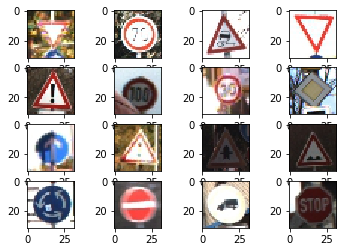

In [18]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import glob

def display_images(images, cmap=None, num_rows=3):
    """
        Displays an image array a grid with number of rows=num_rows
    """
    num_images = len(images)
    num_cols = int(num_images/num_rows)
    fig, axes = plt.subplots(num_rows, num_cols)
    
    for i, ax in enumerate(axes.flat):
        # Only plot the valid images
        if i < num_images:
            img = images[i]

            # Plot image.
            if(cmap):
                ax.imshow(img, cmap=cmap)
            else:
                ax.imshow(img)

def read_images(fileNames, display=True):
    images = []
    for file in fileNames:
        image = cv2.imread(file)
        image = image.astype(np.uint8)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append(image)
    return images    
        
    

test_files = [file for file in glob.glob("gtsrb/*")]


images = read_images(test_files)
display_images(images, num_rows=4)

x_collected = images
y_collected_true = np.array([13, 4, 23, 13, 18, 7, 1, 12, 35, 26, 11, 22, 40, 17, 16,14])

Test Accuracy = 1.000
[13  4 23 13 18  7  1 12 35 26 11 22 40 17 16 14]
[13  4 23 13 18  7  1 12 35 26 11 22 40 17 16 14]


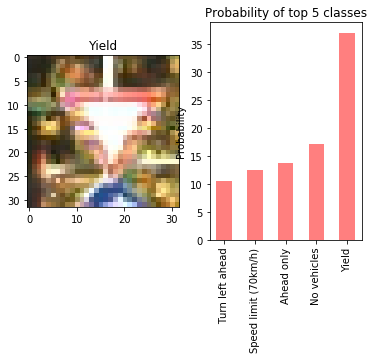

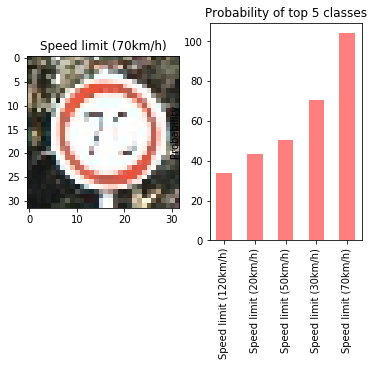

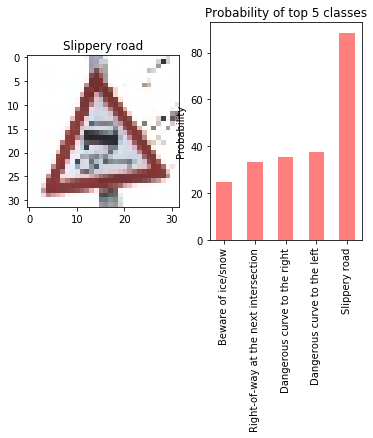

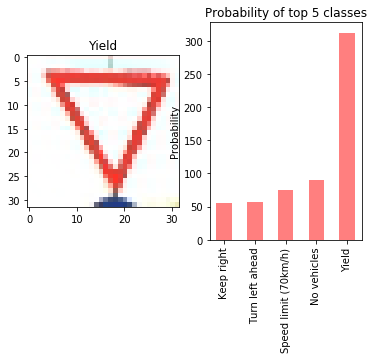

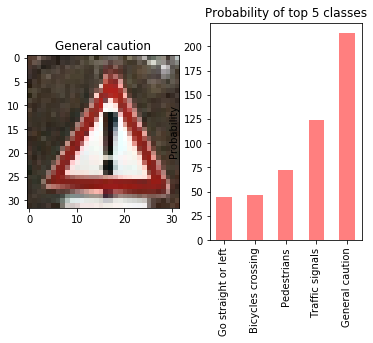

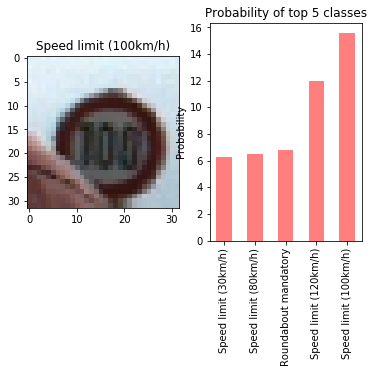

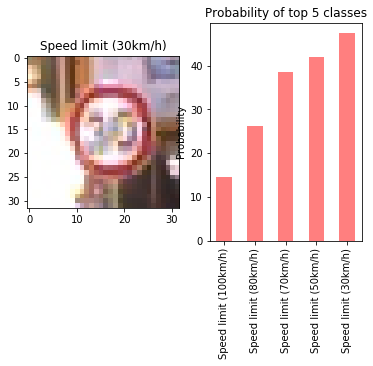

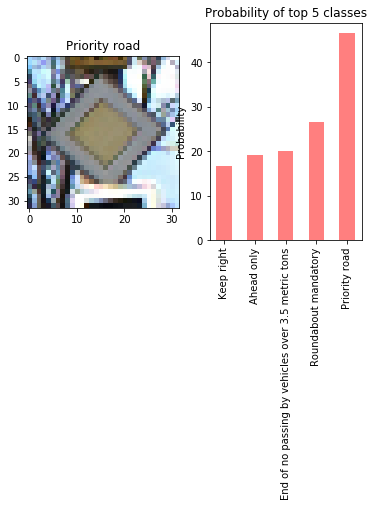

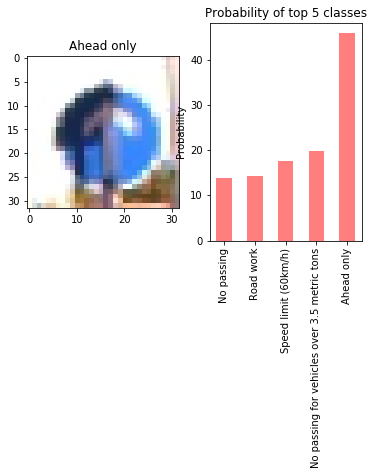

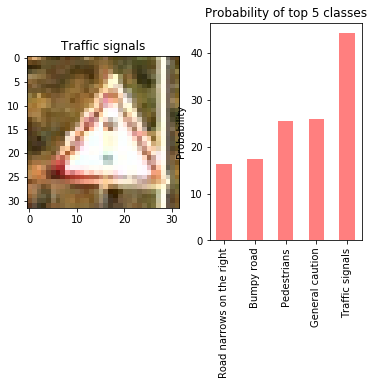

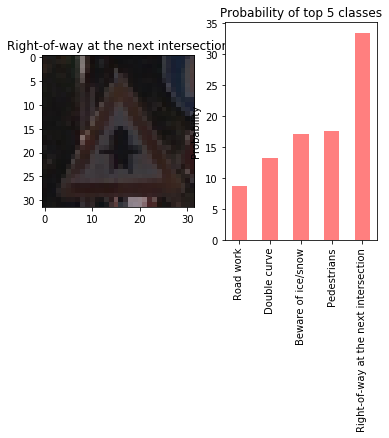

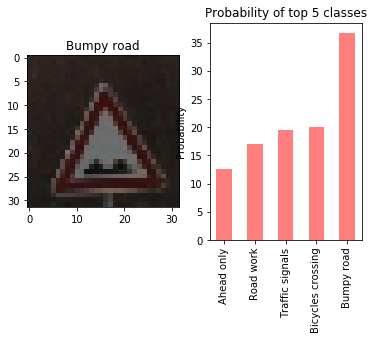

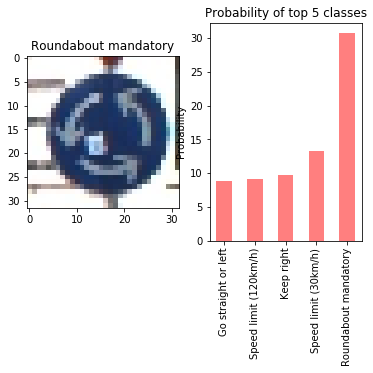

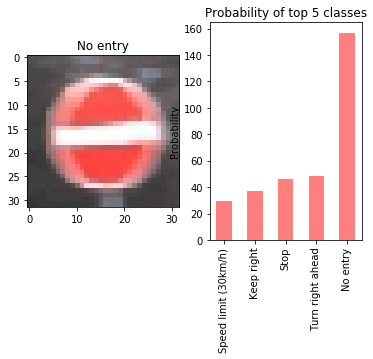

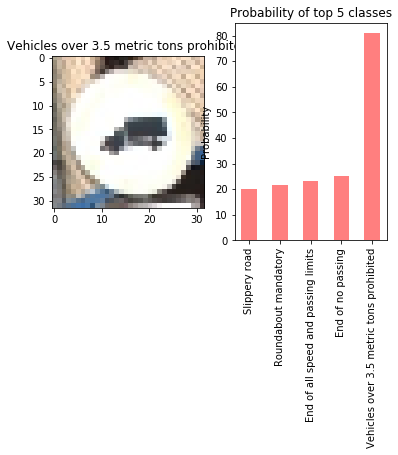

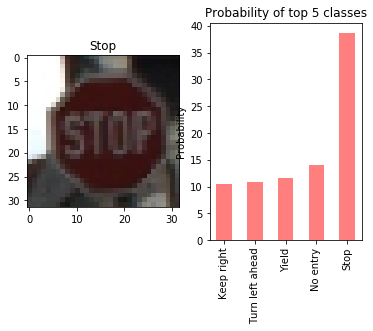

In [19]:
def test_external(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    confusion_valid = ConfusionMatrix(n_classes)
    sess = tf.get_default_session()
    for b_x,b_y in BackgroundGenerator(iterate_minibatches(num_examples,BATCH_SIZE, X_data, y_data,0)):
        batch_x = np.array([x for x in b_x]) #np.fromiter(b_x,float)
        batch_y = np.array([y for y in b_y]) #np.fromiter(b_y,float)
        res = sess.run(logits, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        #top_k = tf.nn.top_k(res, k=5)
        preds = np.argmax(res, 1)
        confusion_valid.batch_add(batch_y, preds)
    return res, preds, confusion_valid


with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    top_k, preds, test_accuracy = test_external(x_collected, y_collected_true)
    er = []
    for en in enumerate(y_collected_true):
        if y_collected_true[en[0]] != preds[en[0]]:
            er.append(en[0])
        
    #print(preds[er==1])
    print("Test Accuracy = {:.3f}".format(test_accuracy.accuracy()))
    print(y_collected_true)
    print(preds)
    if test_accuracy.accuracy() < 1 :
        print("Images were mis-classified:")
        image = x_collected[er[0]]
        y_true = y_collected_true[er[0]]
        y_false = preds[er[0]]
        plt.figure(figsize=(1,1))
        plt.imshow(image)
        print(label_descriptions.get(y_true),y_true)
        print("And it was classifiied as :")
        print(label_descriptions.get(y_false),y_false)
    
    #print(top_k)
    for i, image in enumerate(x_collected):
        # Plot the original image
        plt.subplot(121);
        plt.imshow(image);
        plt.title(label_descriptions.get(y_collected_true[i]));

        # Get the top k probabilities and the classes to which they correspond
        #indices, values = sess.run( [ top_5[i][0], top_5[i][1] ] )
        top_5 = tf.nn.top_k(top_k[i], k=5)
        indices = top_5.indices.eval(session = sess)
        values = top_5.values.eval(session = sess)

        # Sort in ascending order
        idx = values.argsort()
        values = values[idx]
        indices = indices[idx]
        #print(values)
        #print(indices)
        # Show a bar chart of the probabilities
        y_pos = range(0, 200, 40)

        plt.subplot(122)
        plt.bar(y_pos, values, align='center', alpha=0.5, color='red', width=20)

        plt.xticks(y_pos, [label_descriptions.get(ind) for ind in indices])
        locs, labels = plt.xticks()
        plt.setp(labels, rotation=90)

        plt.ylabel('Probability')
        plt.title('Probability of top 5 classes')
        plt.show()

### Performance on New Images
performance on images i got from GTSRB site was pretty well. And I think i got 100% accuracy becuase those images are part of the training set.

### Model Certainty - Softmax Probabilities

As it shown on the output of cell 19, I poltted each image with the True class and how cerain was my model about the pridiction.


## Future Work
I think I can enhance the model by doing the following:

1- Apply more data augmentation as shown here: https://chatbotslife.com/german-sign-classification-using-deep-learning-neural-networks-98-8-solution-d05656bf51ad#.jt0x1iuyh

2- Connet the output of first convoluation layer with second layer into the fully connected layer as suggested on: http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf

3- Apply Spetial Transformation as suggested here: https://arxiv.org/pdf/1511.02992.pdf